In [5]:
import pandas as pd
import os
import glob
import pickle
import pathlib
import matplotlib.pyplot as plt
import numpy as np

In [13]:
# Path to your pickle files
folder_path = 'benchmark_result'
pickle_files = glob.glob(os.path.join(folder_path, '*.pkl'))

# Load each pickle and append to a list

dataframes = []
for file in pickle_files:
    with open(file, 'rb') as f:
        data_dict = pickle.load(f)  # This is a dictionary
        df = pd.DataFrame([data_dict]) if isinstance(data_dict, dict) else pd.DataFrame(data_dict)
        dataframes.append(df)

combined_df = pd.concat(dataframes, ignore_index=True)


In [15]:
combined_df

,workers,threads,memory_limit,chunks,kmeans_mean_time,kmeans_std_time,mem
0,1,2,7 GB,10,17.759582,1.283819,7 GB
1,1,2,7 GB,16,16.560497,1.245626,7 GB
2,1,2,7 GB,4,17.099651,2.073702,7 GB
3,1,2,7 GB,6,18.403944,0.904008,7 GB
4,1,2,7 GB,8,17.040613,1.357955,7 GB
5,1,3,7 GB,10,15.310695,1.679326,7 GB
6,1,3,7 GB,16,15.159425,1.219544,7 GB
7,1,3,7 GB,4,18.859936,1.367803,7 GB
8,1,3,7 GB,6,16.222643,1.531149,7 GB
9,1,3,7 GB,8,16.183774,1.822903,7 GB


In [25]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Clean up data
df = combined_df.copy()
df["memory_limit"] = df["memory_limit"].str.replace(" GB", "").astype(float)
df["mem"] = df["mem"].str.replace(" GB", "").astype(float)

# Mean KMeans Time vs. Chunk Size by Threads

This plot visualizes the relationship between the "Mean KMeans Time" and "Chunk Size," with separate lines for different numbers of "Threads."

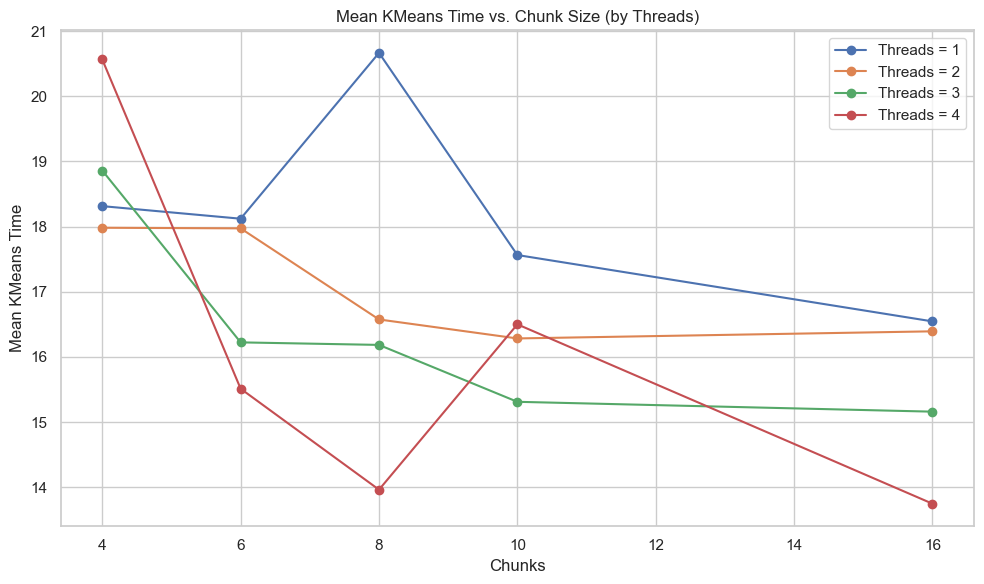

In [29]:
# Plot 1: Mean KMeans Time vs. Chunk Size by Threads
plt.figure(figsize=(10, 6))
for t in sorted(df["threads"].unique()):
    subset = df[df["threads"] == t]
    means = subset.groupby("chunks")["kmeans_mean_time"].mean().sort_index()
    stds = subset.groupby("chunks")["kmeans_mean_time"].std().sort_index()
    chunks = means.index
    plt.plot(chunks, means, marker='o', label=f"Threads = {t}")
    #plt.fill_between(chunks, means - stds, means + stds, alpha=0.2)
plt.title("Mean KMeans Time vs. Chunk Size (by Threads)")
plt.xlabel("Chunks")
plt.ylabel("Mean KMeans Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

As chunks increase, the runtime tends to have a decreasing trend with some fluctuations.

Higher thread counts offer faster processing. 

The lowest KMeans time seems to be achieved with Threads = 4 and Chunks = 16. This suggests that for this KMeans operation, a higher degree of parallelism (4 threads) combined with a large chunk size is most efficient.

# Mean Time by Threads and Workers

This box plot provides a statistical summary of the kmeans_mean_time for different combinations of workers and threads. Each box represents the distribution of mean KMeans times for a specific configuration (e.g., W1, T2 means 1 Worker, 2 Threads).

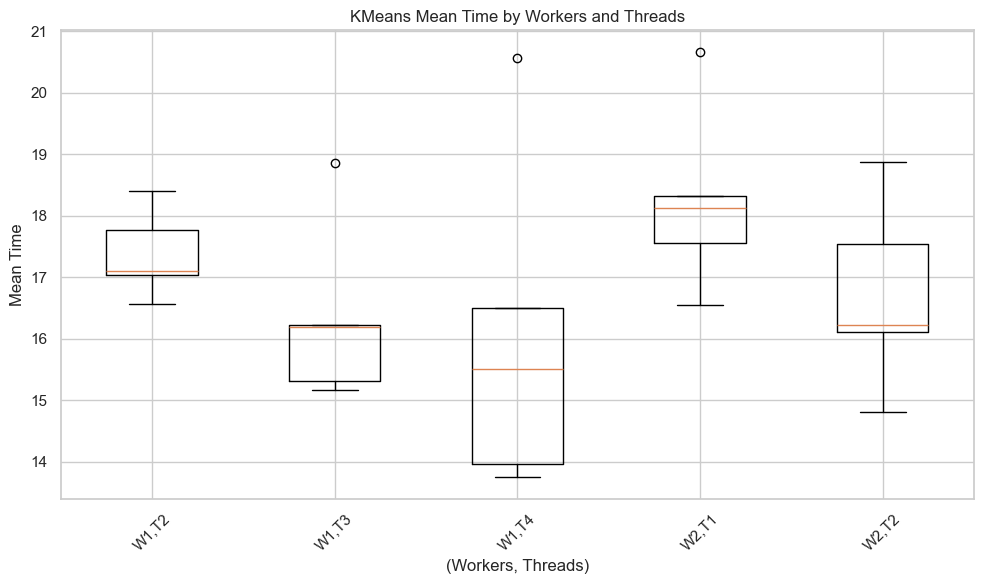

In [33]:
# Plot 2: Boxplot of Mean Time by Threads and Workers
plt.figure(figsize=(10, 6))
grouped = df.groupby(["workers", "threads"])["kmeans_mean_time"]
positions = range(len(grouped))
labels = [f"W{w},T{t}" for (w, t) in grouped.groups.keys()]
data = [grouped.get_group(key) for key in grouped.groups.keys()]
plt.boxplot(data, positions=positions)
plt.xticks(positions, labels, rotation=45)
plt.title("KMeans Mean Time by Workers and Threads")
plt.xlabel("(Workers, Threads)")
plt.ylabel("Mean Time")
plt.grid(True)
plt.tight_layout()
plt.show()

Generally, increasing the number of threads per worker leads to lower KMeans mean times. This indicates that multi-threading is an effective parallelization strategy for this task.

There's a clear trade-off between achieving the absolute lowest time (potentially W1, T4) and having more consistent, predictable performance (W1, T3).

# Mean Time by Workers and Memory

This bar chart displays the average KMeans time for two specific configurations:

W1, M7GB: 1 Worker, 7 GB Memory Limit

W2, M3GB: 2 Workers, 3.5 GB Memory Limit

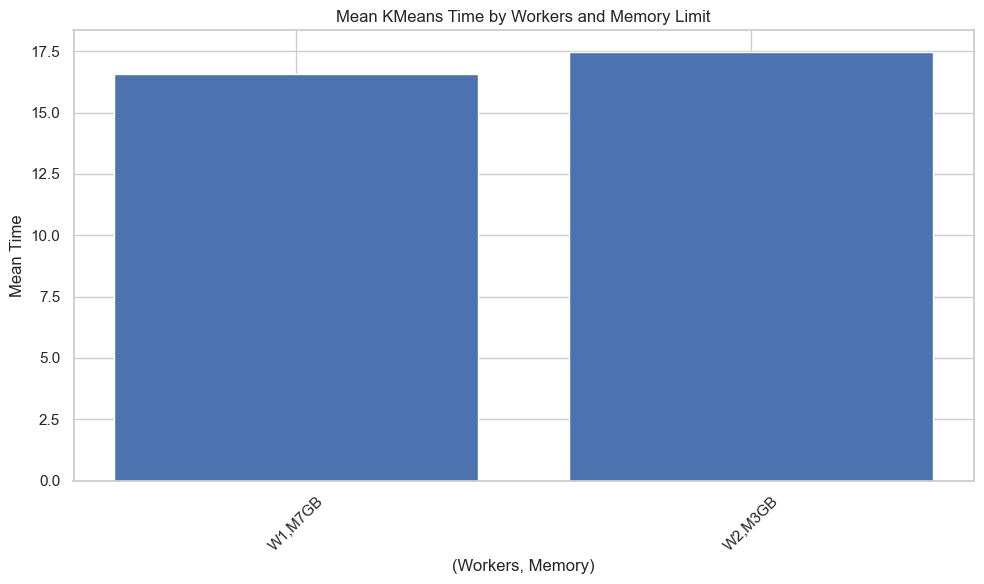

In [44]:
# Plot 3: Bar chart of Mean Time by Workers and Memory
plt.figure(figsize=(10, 6))
grouped = df.groupby(["workers", "mem"])["kmeans_mean_time"].mean()
keys = list(grouped.index)
labels = [f"W{w},M{int(m)}GB" for (w, m) in keys]
plt.bar(labels, grouped.values)
plt.xticks(rotation=45)
plt.title("Mean KMeans Time by Workers and Memory Limit")
plt.xlabel("(Workers, Memory)")
plt.ylabel("Mean Time")
plt.grid(True)
plt.tight_layout()
plt.show()

The W1, M7GB configuration shows a slightly lower mean KMeans time (better performance) than the W2, M3GB configuration.

# Std Dev by Workers and Threads

 This plot shows how the variability (standard deviation) of KMeans time changes with different combinations of workers and threads.

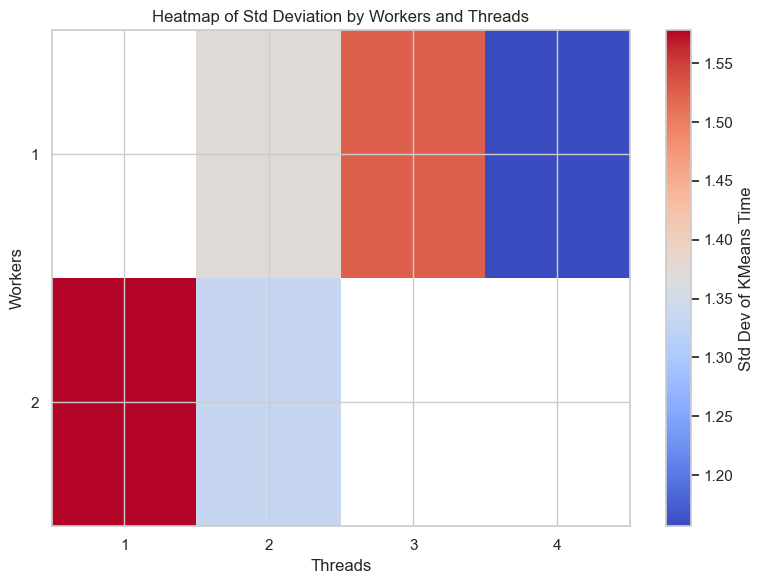

In [46]:
# Plot 4: Heatmap of Std Dev by Workers and Threads
heatmap_data = df.pivot_table(index="workers", columns="threads", values="kmeans_std_time", aggfunc="mean")
plt.figure(figsize=(8, 6))
plt.imshow(heatmap_data, cmap='coolwarm', aspect='auto')
plt.colorbar(label="Std Dev of KMeans Time")
plt.xticks(ticks=np.arange(len(heatmap_data.columns)), labels=heatmap_data.columns)
plt.yticks(ticks=np.arange(len(heatmap_data.index)), labels=heatmap_data.index)
plt.xlabel("Threads")
plt.ylabel("Workers")
plt.title("Heatmap of Std Deviation by Workers and Threads")
plt.tight_layout()
plt.show()

High Variability (Red): W1, T3 and W2, T1. These configurations show higher unpredictability in their KMeans run times.

Low Variability (Blue): W1, T2, W1, T4, and W2, T2. These configurations offer more stable and consistent performance.

# Runtime by Memory

This box plot visualizes the distribution of kmeans_mean_time for different memory limits: 3.5 GB and 7 GB.

C:\Users\yusuf\AppData\Local\Temp\ipykernel_11892\719690152.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[f"{int(m)} GB" for m in mem_labels])


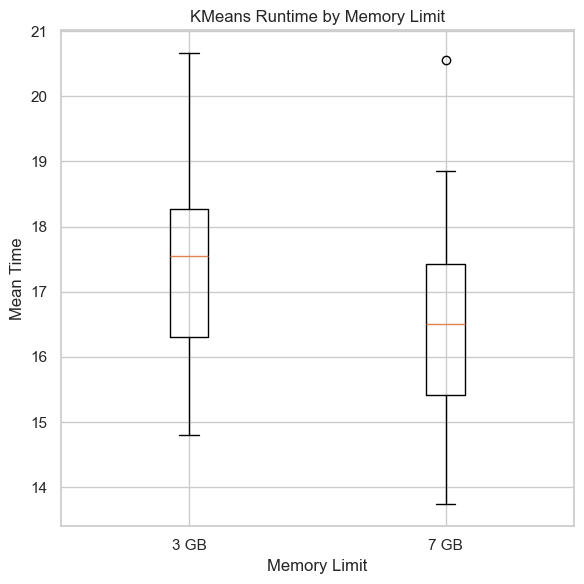

In [55]:
# Plot 5: Boxplot of Runtime by Memory
plt.figure(figsize=(6, 6))
mem_labels = sorted(df["mem"].unique())
data = [df[df["mem"] == m]["kmeans_mean_time"] for m in mem_labels]
plt.boxplot(data, labels=[f"{int(m)} GB" for m in mem_labels])
plt.title("KMeans Runtime by Memory Limit")
plt.xlabel("Memory Limit")
plt.ylabel("Mean Time")
plt.grid(True)
plt.tight_layout()
plt.show()

The plot clearly shows that a higher memory limit (7 GB, associated with 1 worker) is generally associated with faster KMeans mean times and slightly more consistent performance than a lower memory limit (3.5 GB per worker, associated with 2 workers). This suggests that for this KMeans operation, concentrating memory on a single worker (or having a larger total memory pool) is more advantageous than distributing it among multiple workers with less memory individually.

# Scatter (Workers, Threads, Mean Time)

These scatter plots visualize the relationship between "Workers," "Threads," and "Mean KMeans Time" simultaneously.

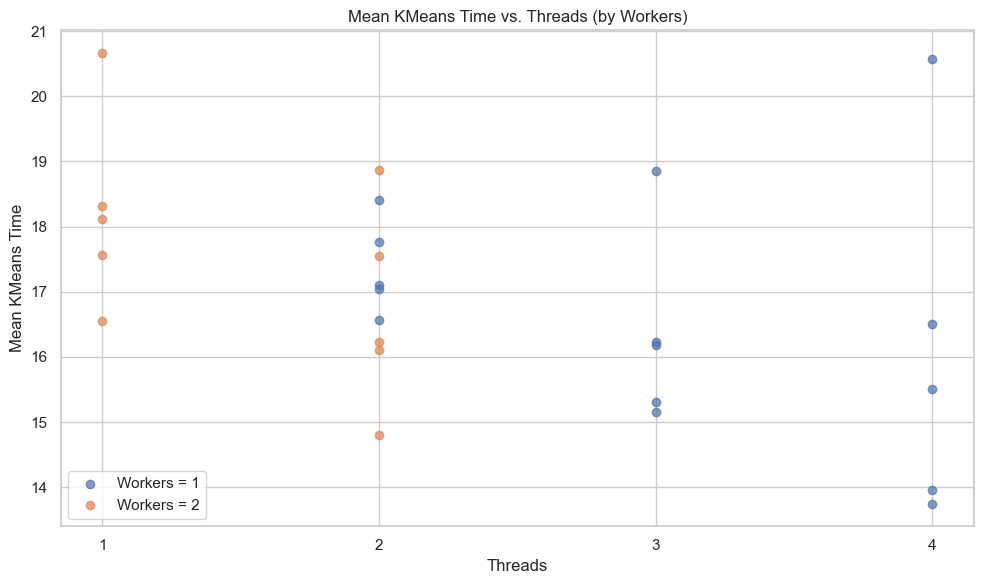

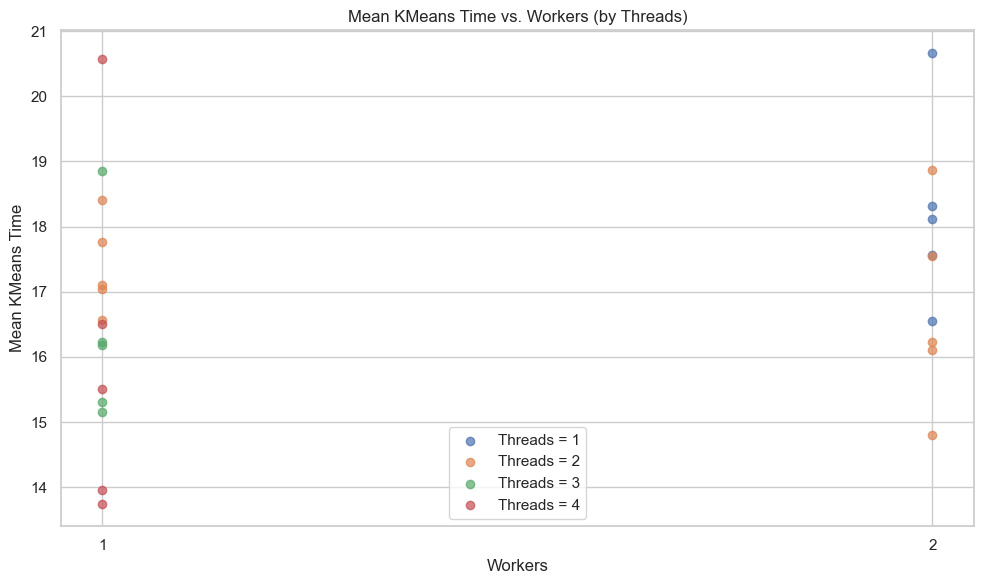

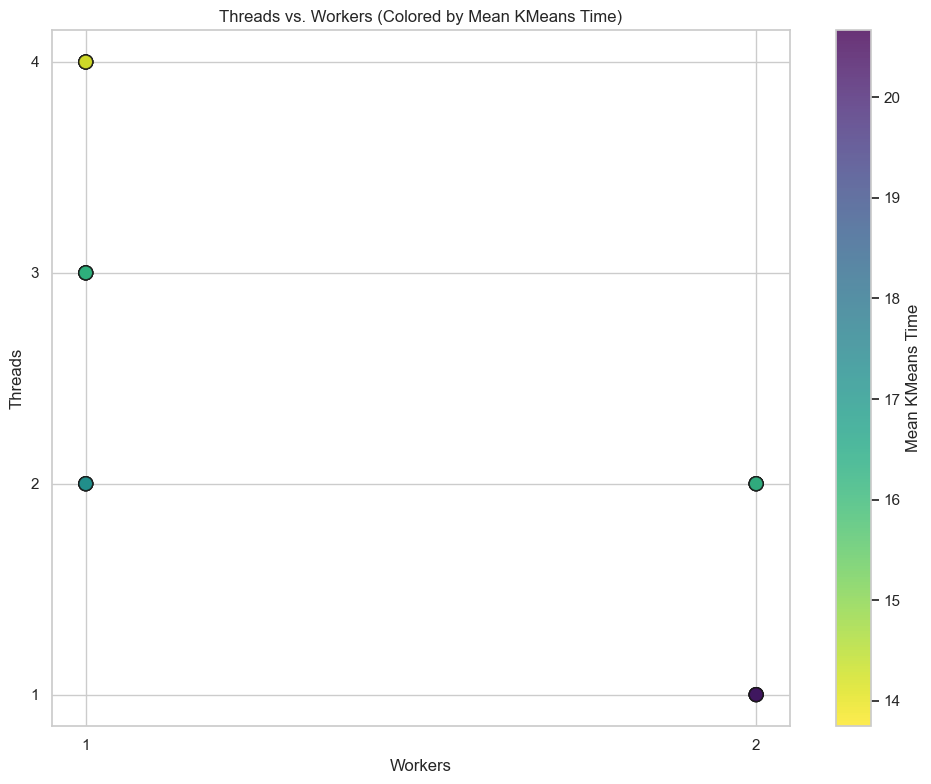

In [62]:
# Plot 6: Scatter (Workers, Threads, Mean Time)

# --- Plot 1: Mean KMeans Time vs. Threads (grouped by Workers) ---
plt.figure(figsize=(10, 6))
workers_unique = sorted(df["workers"].unique())
for worker in workers_unique:
    subset = df[df["workers"] == worker]
    plt.scatter(subset["threads"], subset["kmeans_mean_time"], label=f"Workers = {worker}", alpha=0.7)

plt.title("Mean KMeans Time vs. Threads (by Workers)")
plt.xlabel("Threads")
plt.ylabel("Mean KMeans Time")
plt.xticks(sorted(df["threads"].unique())) # Ensure all thread values are ticks
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot 2: Mean KMeans Time vs. Workers (grouped by Threads) ---
plt.figure(figsize=(10, 6))
threads_unique = sorted(df["threads"].unique())
for thread in threads_unique:
    subset = df[df["threads"] == thread]
    plt.scatter(subset["workers"], subset["kmeans_mean_time"], label=f"Threads = {thread}", alpha=0.7)

plt.title("Mean KMeans Time vs. Workers (by Threads)")
plt.xlabel("Workers")
plt.ylabel("Mean KMeans Time")
plt.xticks(sorted(df["workers"].unique())) # Ensure all worker values are ticks
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot 3: Threads vs. Workers (colored by Mean KMeans Time) ---
plt.figure(figsize=(10, 8))
scatter = plt.scatter(df["workers"], df["threads"], c=df["kmeans_mean_time"], cmap='viridis_r', s=100, alpha=0.8, edgecolor='k')
# viridis_r is reversed viridis, so darker colors are lower mean time (better)
cbar = plt.colorbar(scatter, label="Mean KMeans Time")
plt.title("Threads vs. Workers (Colored by Mean KMeans Time)")
plt.xlabel("Workers")
plt.ylabel("Threads")
plt.xticks(sorted(df["workers"].unique())) # Ensure all worker values are ticks
plt.yticks(sorted(df["threads"].unique())) # Ensure all thread values are ticks
plt.grid(True)
plt.tight_layout()
plt.show()

Thread Impact is Dominant: Across the observed data, increasing the number of threads per worker (from 1 to 2, 3, or 4) generally leads to a reduction in KMeans mean time.

Optimal Performer (among tested configurations): The configuration of 1 Worker and 4 Threads (W1, T4) consistently shows the potential for the lowest KMeans mean times. However, it also has some instances of significantly higher times (outliers).

Worst Performers: Configurations with only 1 Thread per worker (W1, T1 and W2, T1) consistently result in the highest KMeans mean times, indicating that parallelization through threads is crucial for this task.

# Std Deviation vs Chunk Size by Threads

This plot, titled "Std Deviation of KMeans Time vs Chunk Size," shows how the variability (standard deviation) of KMeans runtime changes with different chunk sizes, segmented by the number of threads.

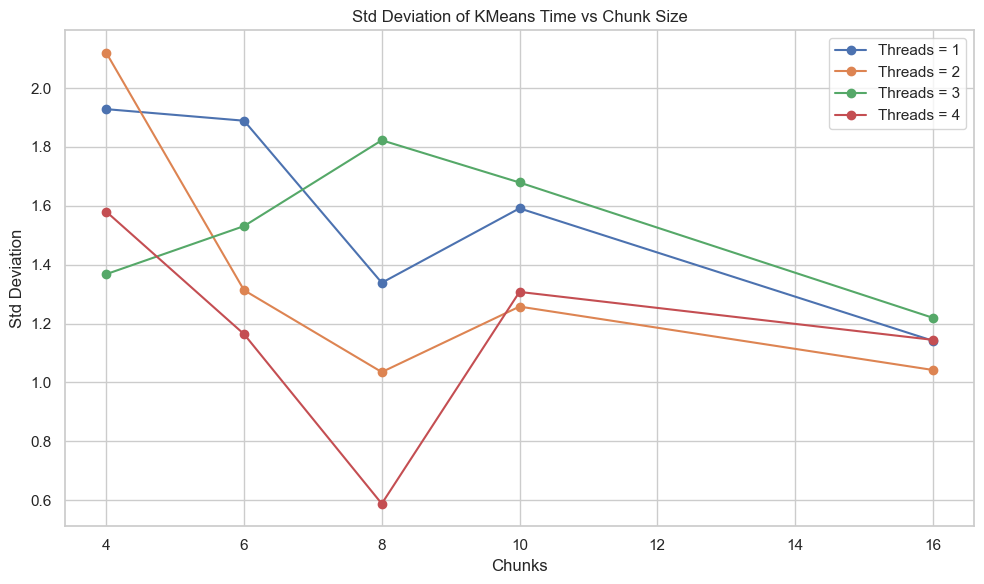

In [66]:
# Plot 7: Std Deviation vs Chunk Size by Threads
plt.figure(figsize=(10, 6))
for t in sorted(df["threads"].unique()):
    subset = df[df["threads"] == t]
    means = subset.groupby("chunks")["kmeans_std_time"].mean().sort_index()
    plt.plot(means.index, means.values, marker='o', label=f"Threads = {t}")
plt.title("Std Deviation of KMeans Time vs Chunk Size")
plt.xlabel("Chunks")
plt.ylabel("Std Deviation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Chunk size significantly and non-linearly impacts the standard deviation of KMeans time. There isn't a "one-size-fits-all" optimal chunk size for consistency across all thread counts.

The absolute most consistent performance (lowest standard deviation) is achieved with Threads = 4 and Chunks = 8 (std dev around 0.58)

# Mean KMeans Time with Std Dev as Error Bars by Chunk Size

This plot, "Mean KMeans Time with Std Dev by Chunk Size," is an error bar plot that shows the overall mean KMeans time across all worker and thread configurations for different chunk sizes, with the standard deviation represented as error bars.

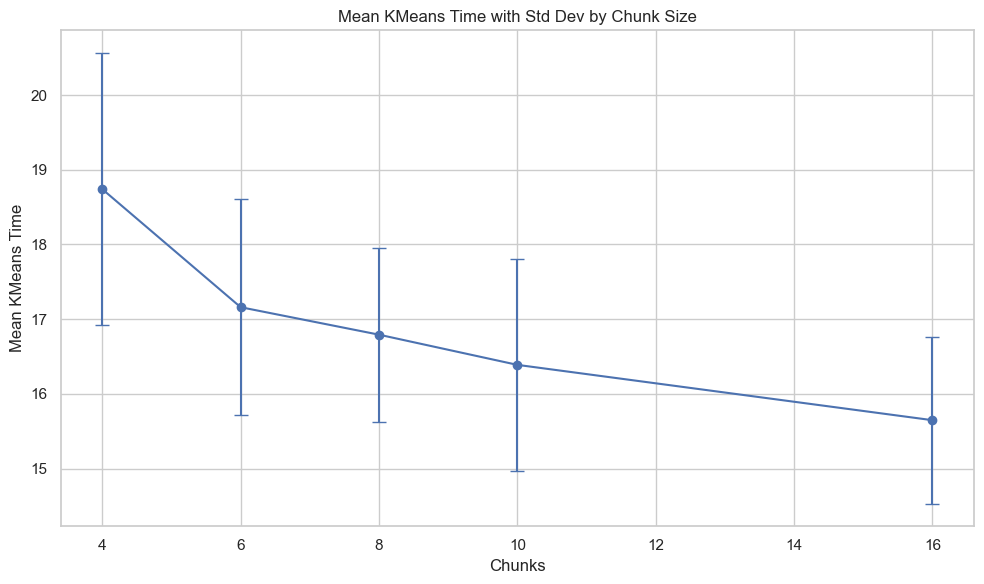

In [69]:
# Plot 8: Mean KMeans Time with Std Dev as Error Bars by Chunk Size
plt.figure(figsize=(10, 6))
grouped = df.groupby("chunks")[["kmeans_mean_time", "kmeans_std_time"]].mean().sort_index()
plt.errorbar(grouped.index, grouped["kmeans_mean_time"], yerr=grouped["kmeans_std_time"], fmt='o-', capsize=5)
plt.title("Mean KMeans Time with Std Dev by Chunk Size")
plt.xlabel("Chunks")
plt.ylabel("Mean KMeans Time")
plt.grid(True)
plt.tight_layout()
plt.show()

For the KMeans operation, increasing the chunk size generally leads to both faster average execution times and more consistent (less variable) performance.